# **Alibaba Stock Price Forecasting: EDA, Traditional and Deep Learning Approaches with Explainable AI Insights**

## **Part 1 - Data Explanatory Analysis**

### **1. Initialization**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import shap
import lime
import lime.lime_tabular


### **2. Load dataset file**

In [2]:
data = pd.read_csv('Ali_Baba_Stock_Data.csv')

In [3]:
# Check dataset shape
data.shape

(2617, 7)

In [4]:
# Check dataset head
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000


In [5]:
# Check data types
data.dtypes

Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

### **3. Initial data cleaning**

In [6]:
# Convert Date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

In [7]:
# Check column format
data.dtypes

Date         datetime64[ns]
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object

### **4. Explore dataset**

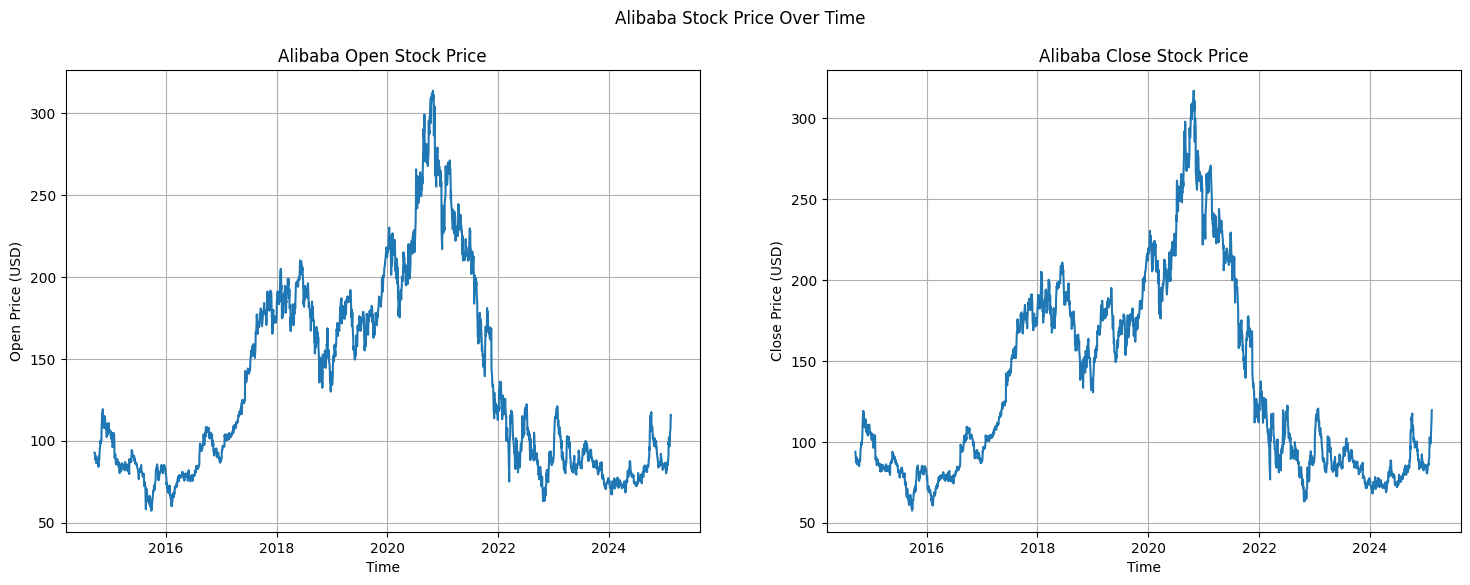

In [8]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Alibaba Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Alibaba Close Stock Price")
plt.grid()

plt.suptitle("Alibaba Stock Price Over Time")
plt.show()

In [9]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Check filtered data shape
data_5years.shape

(1539, 7)

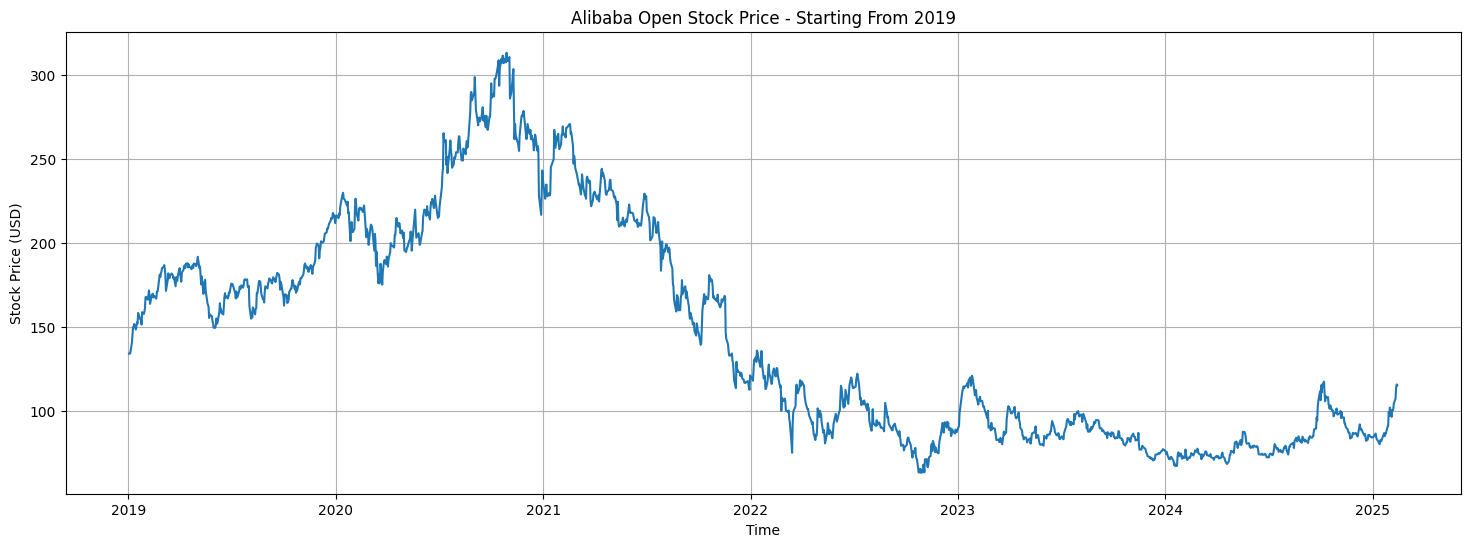

In [10]:
# Plot Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Alibaba Open Stock Price - Starting From 2019")
plt.grid()

### **5. Store filtered dataset**

In [11]:
# Prepare data file location
data_file_name = "Ailibaba_stock_price_recent"
data_file_ext = "csv"

# Store dataset
data_5years.to_csv(data_file_name + "." + data_file_ext, index=None)

In [12]:
# Set output width
pd.set_option("display.width", 120)

In [13]:
data = pd.read_csv("Ailibaba_stock_price_recent.csv")
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-01-02,132.017563,136.699997,137.748993,133.029999,134.130005,16708400
1,2019-01-03,126.126511,130.600006,134.869995,129.830002,134.270004,19531300
2,2019-01-04,134.963089,139.750000,141.080002,133.660004,134.259995,22845400
3,2019-01-07,138.198349,143.100006,144.080002,139.009995,140.550003,17239000
4,2019-01-08,141.761932,146.789993,147.550003,142.059998,145.000000,16487600
...,...,...,...,...,...,...,...
1534,2025-02-07,103.510002,103.510002,107.510002,103.000000,104.459999,39538200
1535,2025-02-10,111.320000,111.320000,111.650002,106.699997,107.320000,42429400
1536,2025-02-11,112.779999,112.779999,115.540001,111.000000,113.959999,55001300
1537,2025-02-12,118.330002,118.330002,119.809998,114.964996,115.820000,44024700


In [14]:
# Check loaded data shape
data.shape

(1539, 7)

In [15]:
# Check loaded data head
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-01-02,132.017563,136.699997,137.748993,133.029999,134.130005,16708400
1,2019-01-03,126.126511,130.600006,134.869995,129.830002,134.270004,19531300
2,2019-01-04,134.963089,139.750000,141.080002,133.660004,134.259995,22845400
3,2019-01-07,138.198349,143.100006,144.080002,139.009995,140.550003,17239000
4,2019-01-08,141.761932,146.789993,147.550003,142.059998,145.000000,16487600


In [16]:
# Check columns types
data.dtypes

Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

### **6. Data preprocessing**

In [17]:
# Convert date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

Date         datetime64[ns]
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object

In [18]:
# Define selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

In [19]:
# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [20]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1132, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


In [21]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
         Open        High         Low       Close   Adj Close    Volume
0  134.130005  137.748993  133.029999  136.699997  132.017563  16708400
1  134.270004  134.869995  129.830002  130.600006  126.126511  19531300
2  134.259995  141.080002  133.660004  139.750000  134.963089  22845400
3  140.550003  144.080002  139.009995  143.100006  138.198349  17239000
4  145.000000  147.550003  142.059998  146.789993  141.761932  16487600
Validation Dataset:
           Open       High        Low      Close  Adj Close    Volume
1132  84.870003  85.635002  84.000000  84.070000  81.190315  11514400
1133  83.980003  84.690002  82.820000  84.300003  81.412445  11203900
1134  83.120003  83.949997  82.639999  83.839996  80.968193  12930300
1135  86.760002  91.570000  86.629997  90.550003  87.448357  46815900
1136  90.050003  92.040001  89.599998  90.559998  87.458015  25401800
Testing Dataset:
           Open       High        Low      Close  Adj Close    Volume
1258  76.050003  76.074

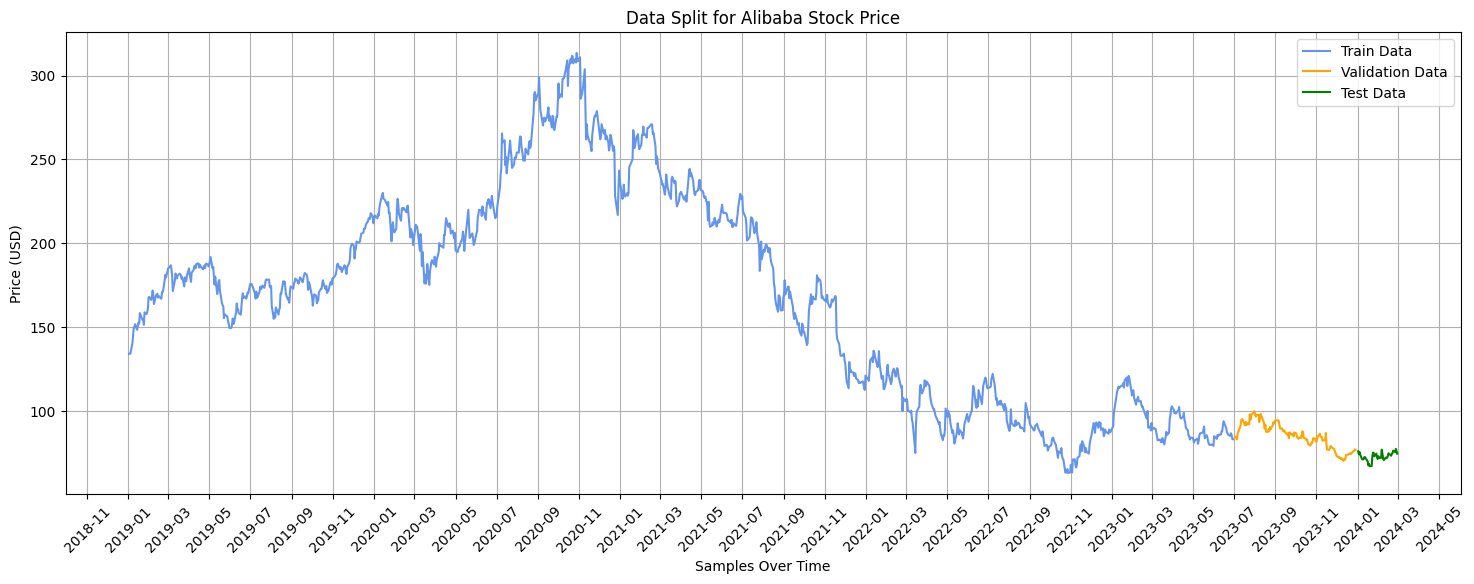

In [22]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Alibaba Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [23]:
# Check the distribution of input features
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1.539000e+03
mean,146.116238,147.994357,144.058359,146.056498,141.459253,1.985245e+07
std,65.664235,66.207690,64.818779,65.568657,62.962781,1.269429e+07
min,63.200001,64.099998,58.009998,63.150002,60.986900,5.235400e+06
25%,86.405499,87.529999,85.349998,86.200001,84.369667,1.253520e+07
50%,120.930000,123.940002,118.589996,122.099998,118.052864,1.686870e+07
75%,198.989998,201.294998,196.564995,199.450005,192.618164,2.255730e+07
max,313.500000,319.320007,308.910004,317.140015,306.276886,1.598343e+08


In [24]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

### **7. Storing processed datasets**

In [25]:
# Prepare scaler model name and location
scaler_model_location = "D://SP25//DAP391m//models//"
scaler_model_name = "alibaba_stock_price_scaler"
scaler_model_ext = "gz"
# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['D://SP25//DAP391m//models//alibaba_stock_price_scaler.gz']

In [26]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [27]:
# Prepare datasets files and location
data_file_location = "D://SP25//DAP391m//data//processed//"
data_file_name_train = "alibaba_stock_price_processed_train"
data_file_name_validate = "alibaba_stock_price_processed_validate"
data_file_name_test = "alibaba_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

## **Part 2 - Model Training**

### **A - ARIMA AND SARIMA**

### **1. ARIMA Model Implementation**

In [ ]:
# Load data files
data_train_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_train.csv")
data_validate_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_validate.csv")
data_test_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_test.csv")

In [30]:
# Convert 'Date' column to datetime for both training and testing sets
data_train_df['Date'] = pd.to_datetime(data_train_df['Date'])
data_validate_df['Date'] = pd.to_datetime(data_validate_df['Date'])
data_test_df['Date'] = pd.to_datetime(data_test_df['Date'])

# Set 'Date' column as the index
data_train_df.set_index('Date', inplace=True)
data_validate_df.set_index('Date', inplace=True)
data_test_df.set_index('Date', inplace=True)

# Define the feature for forecasting (Open stock price)
train_open = data_train_df['Open']
validate_open = data_validate_df['Open']
test_open = data_test_df['Open']


In [38]:
# Fit ARIMA model to training data
arima_model = ARIMA(train_open, order=(5, 1, 0))  # Example order, you might want to tune this
arima_fitted = arima_model.fit()

# Forecasting
arima_forecast = arima_fitted.forecast(steps=len(validate_open))


C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given wit

In [39]:
# Evaluate ARIMA model
arima_rmse = sqrt(mean_squared_error(validate_open, arima_forecast))
arima_mae = mean_absolute_error(validate_open, arima_forecast)

print(f"ARIMA Model - RMSE: {arima_rmse}")
print(f"ARIMA Model - MAE: {arima_mae}")

ARIMA Model - RMSE: 0.03158090804951424
ARIMA Model - MAE: 0.026060411170079022


### **2. SARIMA Model Implementation**

In [40]:
# Fit SARIMA model to training data
sarima_model = SARIMAX(train_open, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Example seasonal order
sarima_fitted = sarima_model.fit()

# Forecasting
sarima_forecast = sarima_fitted.forecast(steps=len(validate_open))

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

In [41]:
# Evaluate SARIMA model
sarima_rmse = sqrt(mean_squared_error(validate_open, sarima_forecast))
sarima_mae = mean_absolute_error(validate_open, sarima_forecast)

print(f"SARIMA Model - RMSE: {sarima_rmse}")
print(f"SARIMA Model - MAE: {sarima_mae}")

SARIMA Model - RMSE: 0.031014269664924026
SARIMA Model - MAE: 0.025928283561188526


### **3. Plot the Results**

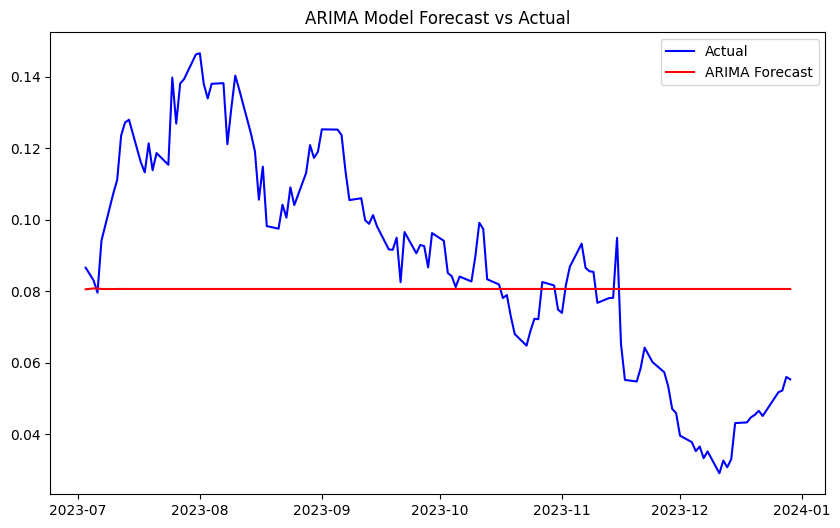

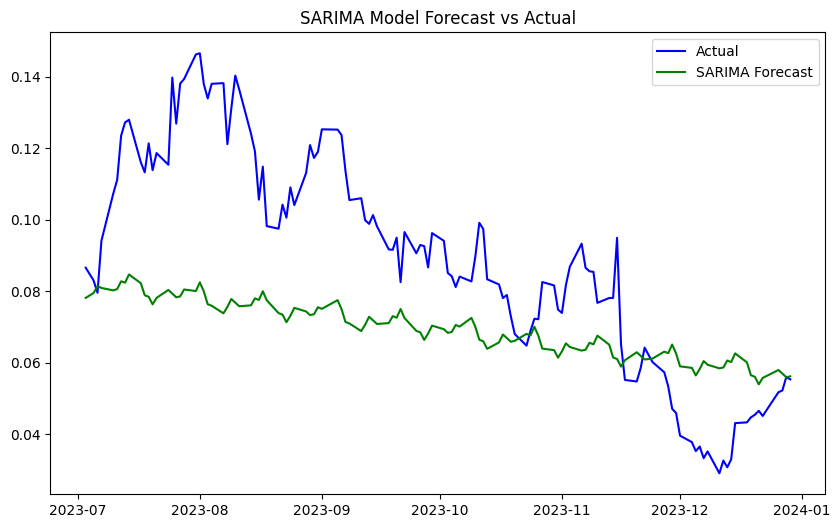

In [42]:
# Plot ARIMA results
plt.figure(figsize=(10, 6))
plt.plot(validate_open, label='Actual', color='blue')
plt.plot(validate_open.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.legend()
plt.show()

# Plot SARIMA results
plt.figure(figsize=(10, 6))
plt.plot(validate_open, label='Actual', color='blue')
plt.plot(validate_open.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('SARIMA Model Forecast vs Actual')
plt.legend()
plt.show()

### **B - LSTM TIME SERIES**

### **1. Loading datasets**

In [29]:
# Load data files
data_train_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_train.csv")
data_validate_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_validate.csv")
data_test_df = pd.read_csv(".//data//processed//alibaba_stock_price_processed_test.csv")

In [29]:
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [30]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.283380  0.288571  0.299004  0.289578   0.289578  0.072486  2019-01-02
1  0.283939  0.277290  0.286250  0.265562   0.265562  0.090779  2019-01-03
2  0.283899  0.301622  0.301515  0.301587   0.301587  0.112256  2019-01-04
3  0.309029  0.313377  0.322838  0.314776   0.314776  0.075924  2019-01-07
4  0.326808  0.326973  0.334994  0.329304   0.329304  0.071055  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.086576  0.084378  0.103587  0.082365   0.082365  0.038827  2023-07-03
1  0.083020  0.080676  0.098884  0.083271   0.083271  0.036815  2023-07-05
2  0.079585  0.077776  0.098167  0.081460   0.081460  0.048002  2023-07-06
3  0.094127  0.107633  0.114069  0.107878   0.107878  0.267595  2023-07-07
4  0.107271  0.109474  0.125907  0.107918   0.107918  0.128823  2023-07-10
Testing Dataset:
       Open      High       Low     Close  Ad

### **2. Data preprocessing**

In [31]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [110]:
# Extract features
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

### **3. Constructing data structure**

In [33]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [34]:
sequence_size = 60

In [44]:
# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [45]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

In [46]:
# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

In [47]:
# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

In [48]:
# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [49]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1132, 6)
> Data Train X: (1072, 60, 6)
> Data Train y: (1072,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


In [50]:
# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [51]:
# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validate_dataset = TensorDataset(X_validate_tensor, y_validate_tensor)
validate_loader = DataLoader(validate_dataset, batch_size=64, shuffle=False)

### **4. Training LSTM model**

In [52]:
# Define the LSTM model using PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc(x[:, -1, :])  # Get the last time step's output
        return x

In [53]:
# Initialize the model
model = LSTMModel(input_size=X_train.shape[2], hidden_size=100, output_size=1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [54]:
def train_model(model, train_loader, validate_loader, criterion, optimizer, epochs=200):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # targets need to be reshaped
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validate_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()

        val_losses.append(val_loss / len(validate_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "D://SP25//DAP391m//models//alibaba_stock_price_lstm.pth")
    
    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, validate_loader, criterion, optimizer)

Epoch 1/200, Train Loss: 0.09188824388034203, Validation Loss: 0.06988264061510563
Epoch 2/200, Train Loss: 0.015304801054298878, Validation Loss: 0.006540494505316019
Epoch 3/200, Train Loss: 0.00484050321392715, Validation Loss: 0.001590351457707584
Epoch 4/200, Train Loss: 0.0028474696925567355, Validation Loss: 0.0009104557684622705
Epoch 5/200, Train Loss: 0.0020775648710482262, Validation Loss: 0.00047551013994961977
Epoch 6/200, Train Loss: 0.001763301038676325, Validation Loss: 0.0006019116117386147
Epoch 7/200, Train Loss: 0.0016501034089528462, Validation Loss: 0.0003808632318396121
Epoch 8/200, Train Loss: 0.001550537465578493, Validation Loss: 0.0002656359429238364
Epoch 9/200, Train Loss: 0.0017695854869945085, Validation Loss: 0.000370683177607134
Epoch 10/200, Train Loss: 0.0014948617831310805, Validation Loss: 0.0003943165866076015
Epoch 11/200, Train Loss: 0.0014546273091314908, Validation Loss: 0.00024168438540073112
Epoch 12/200, Train Loss: 0.0012967051280771986, Va

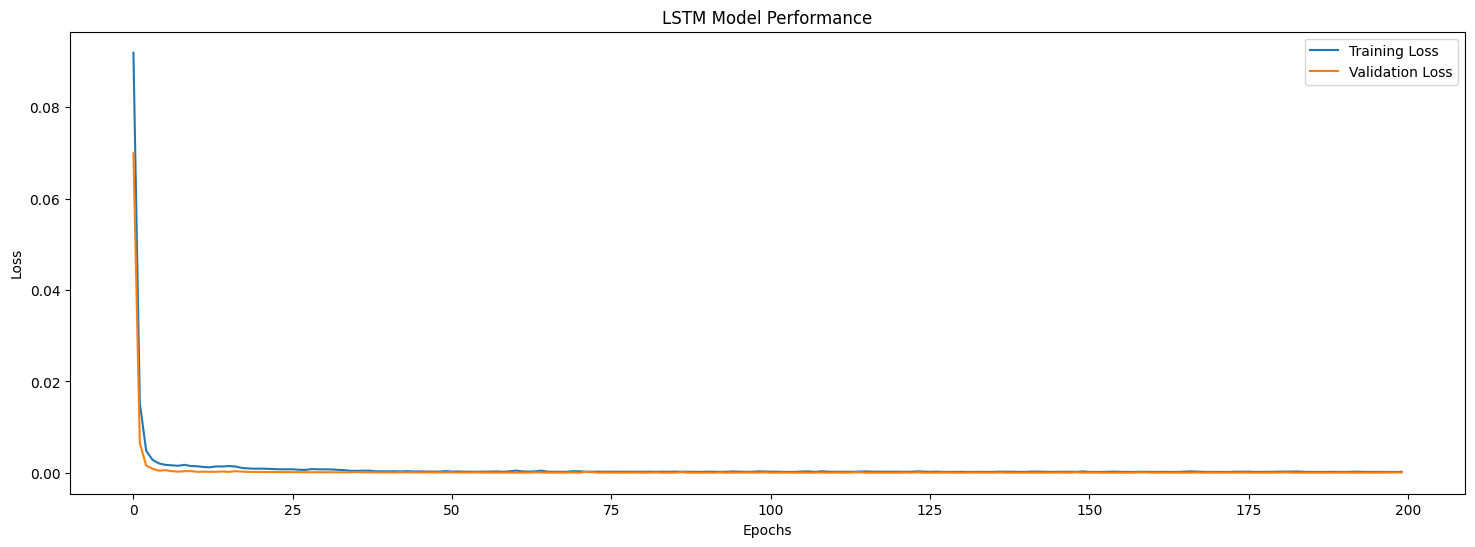

In [55]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **5. Evaluation of LSTM**

In [56]:
# Load the best performing model
model.load_state_dict(torch.load("D://SP25//DAP391m//models//alibaba_stock_price_lstm.pth"))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11904\2129052029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("D://SP25//DAP391m//models/

<All keys matched successfully>

In [57]:
model.eval()
y_train_predict = model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
y_validate_predict = model(torch.tensor(X_validate, dtype=torch.float32)).detach().numpy()
y_test_predict = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

In [58]:
# Prepare scaler model name and location
scaler_model_location = "D://SP25//DAP391m//models//"
scaler_model_name = "alibaba_stock_price_scaler"
scaler_model_ext = "gz"
# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [59]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

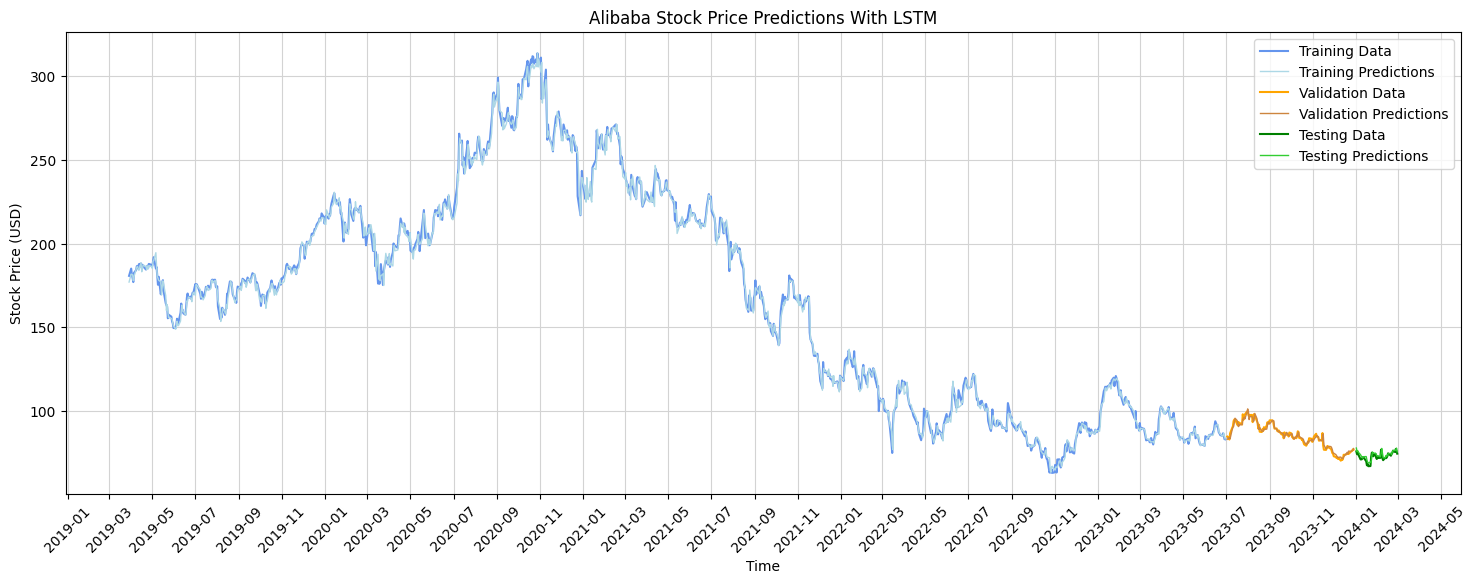

In [60]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Alibaba Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

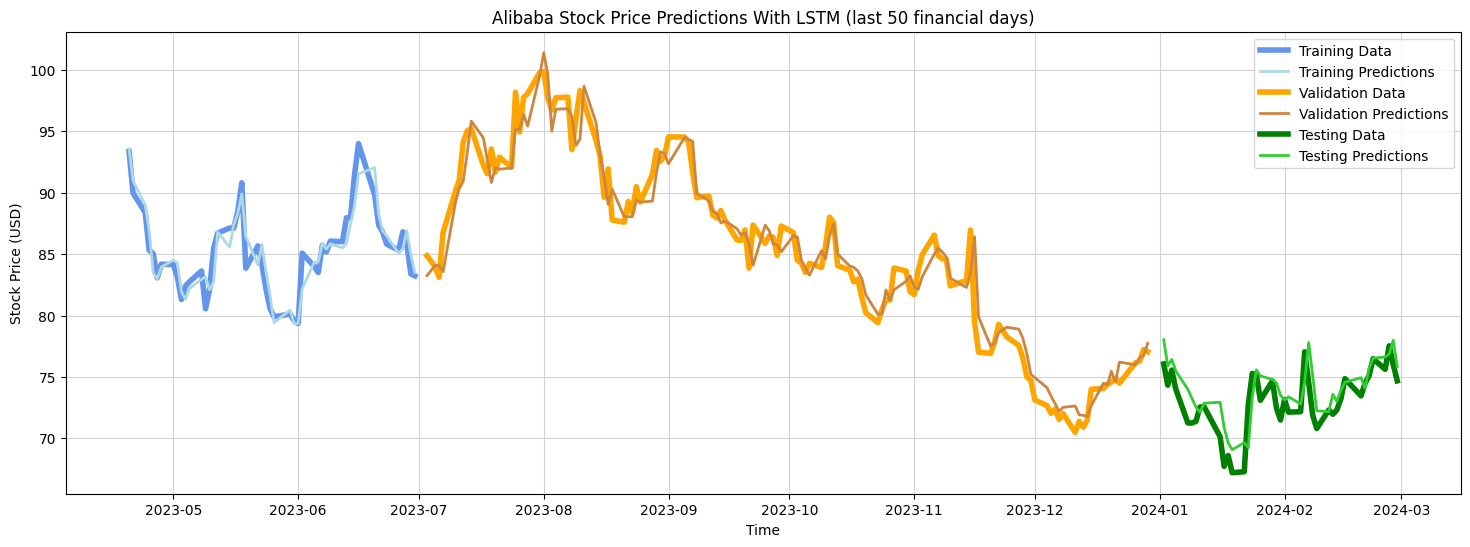

In [61]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:], y_train_inv[-recent_samples:], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:], y_train_predict_inv[-recent_samples:], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Alibaba Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(color="lightgray")

### **6. Training Transformer model**

In [65]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead=8):
        super(TransformerModel, self).__init__()
        
        # Transformer encoder and decoder layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nhead = nhead
        
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Define the Transformer model with encoder-decoder layers
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout=0.1)
        
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer to map to output
        
    def forward(self, x):
        # Prepare the input sequence
        x = self.embedding(x)
        
        # Reshape to match Transformer input dimensions [seq_len, batch_size, feature_dim]
        x = x.permute(1, 0, 2)  # Transform to (seq_len, batch_size, feature_dim) for PyTorch's Transformer
        
        # Pass through the transformer
        transformer_out = self.transformer(x, x)  # Encoder-decoder approach
        
        # Only use the last output in the sequence for prediction (regression)
        output = self.fc(transformer_out[-1, :, :])  # (batch_size, output_size)
        return output

# Initialize the Transformer model
input_size = X_train.shape[2]  # Number of features (Open, High, Low, etc.)
hidden_size = 64  # Size of the hidden layer
num_layers = 2  # Number of layers in Transformer
output_size = 1  # Output stock price

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Training the Transformer model
def train_transformer_model(model, train_loader, validate_loader, criterion, optimizer, epochs=200):
    best_val_loss = float('inf')
    train_losses_ = []
    val_losses_ = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # targets need to be reshaped
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses_.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validate_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()

        val_losses_.append(val_loss / len(validate_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses_[-1]}, Validation Loss: {val_losses_[-1]}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "D://SP25//DAP391m//models//alibaba_stock_price_transformer.pth")
    
    return train_losses_, val_losses_

train_losses_, val_losses_ = train_transformer_model(transformer_model, train_loader, validate_loader, criterion, optimizer)


C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Train Loss: 0.7328369437771685, Validation Loss: 0.008467584382742643
Epoch 2/200, Train Loss: 0.08430865867172971, Validation Loss: 0.058080025017261505
Epoch 3/200, Train Loss: 0.04472628887742758, Validation Loss: 0.014951618853956461
Epoch 4/200, Train Loss: 0.013654970098286867, Validation Loss: 0.00147098716115579
Epoch 5/200, Train Loss: 0.010024378432289642, Validation Loss: 0.004825801937840879
Epoch 6/200, Train Loss: 0.00821222337510656, Validation Loss: 0.0010937542901956476
Epoch 7/200, Train Loss: 0.006648828522028292, Validation Loss: 0.0009553869458613917
Epoch 8/200, Train Loss: 0.005931671927956974, Validation Loss: 0.0003829097477137111
Epoch 9/200, Train Loss: 0.0049673936001079924, Validation Loss: 0.003613700973801315
Epoch 10/200, Train Loss: 0.0043387225938632205, Validation Loss: 0.0005778179620392621
Epoch 11/200, Train Loss: 0.003802070421550204, Validation Loss: 0.0010946586116915569
Epoch 12/200, Train Loss: 0.0036518005654215813, Validation Lo

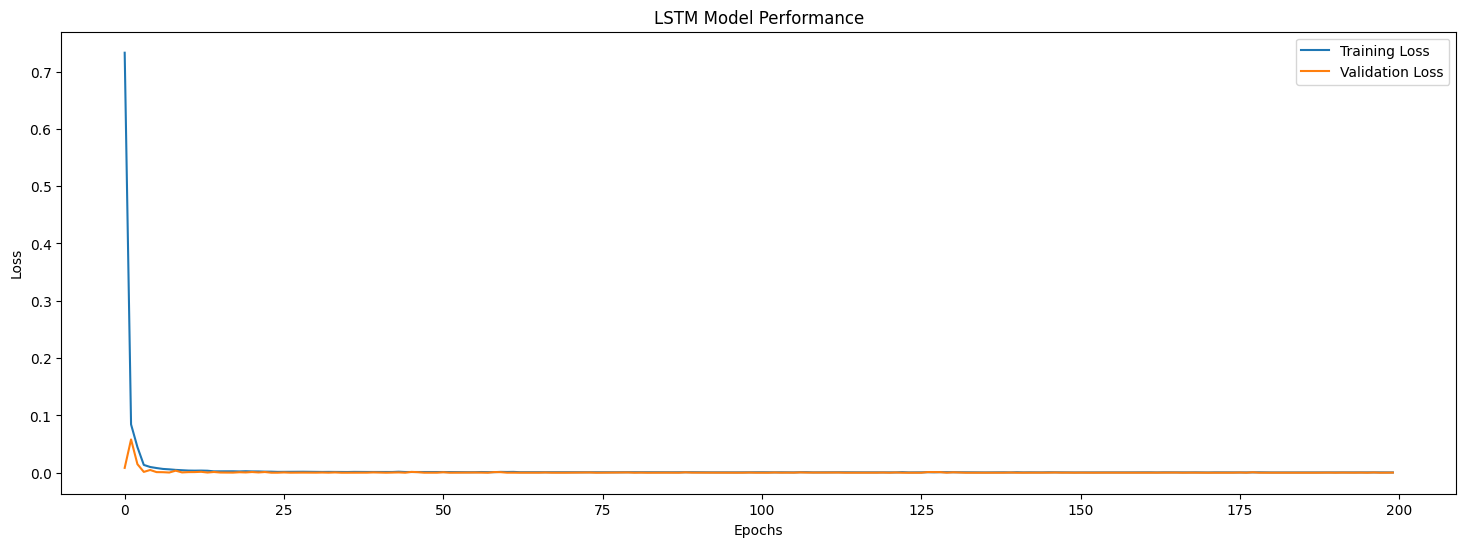

In [66]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))
plt.plot(train_losses_, label="Training Loss")
plt.plot(val_losses_, label="Validation Loss")
plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **7. Evaluation of Transformer**

In [67]:
# Load the best performing Transformer model
transformer_model.load_state_dict(torch.load("D://SP25//DAP391m//models//alibaba_stock_price_transformer.pth"))
transformer_model.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11904\555334008.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load("D://SP25//DAP39

TransformerModel(
  (embedding): Linear(in_features=6, out_features=64, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x Trans

In [68]:
# Generate predictions for train, validation, and test sets using the Transformer model
y_train_predict = transformer_model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
y_validate_predict = transformer_model(torch.tensor(X_validate, dtype=torch.float32)).detach().numpy()
y_test_predict = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

In [69]:
# Prepare scaler model name and location
scaler_model_location = "D://SP25//DAP391m//models//"
scaler_model_name = "alibaba_stock_price_scaler"
scaler_model_ext = "gz"

In [70]:
# Load the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [71]:
# Restore actual distribution for predicted prices (inverse transform)
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.ones((len(y_train.reshape(-1, 1)), 5))), axis=1))[:, 0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1, 1), np.ones((len(y_validate.reshape(-1, 1)), 5))), axis=1))[:, 0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.ones((len(y_test.reshape(-1, 1)), 5))), axis=1))[:, 0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:, 0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:, 0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:, 0]

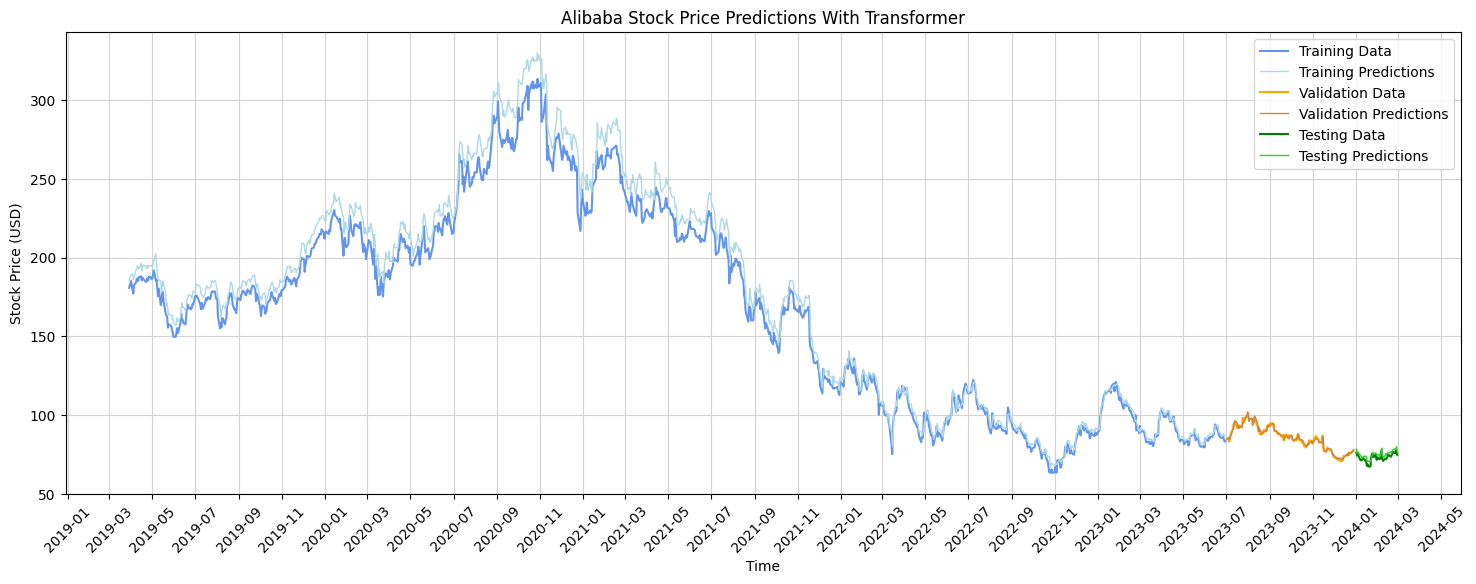

In [72]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

# Plot actual and predicted prices for the full dataset
plt.figure(figsize=(18, 6))
plt.plot(data_train_dates[sequence_size:], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Alibaba Stock Price Predictions With Transformer")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

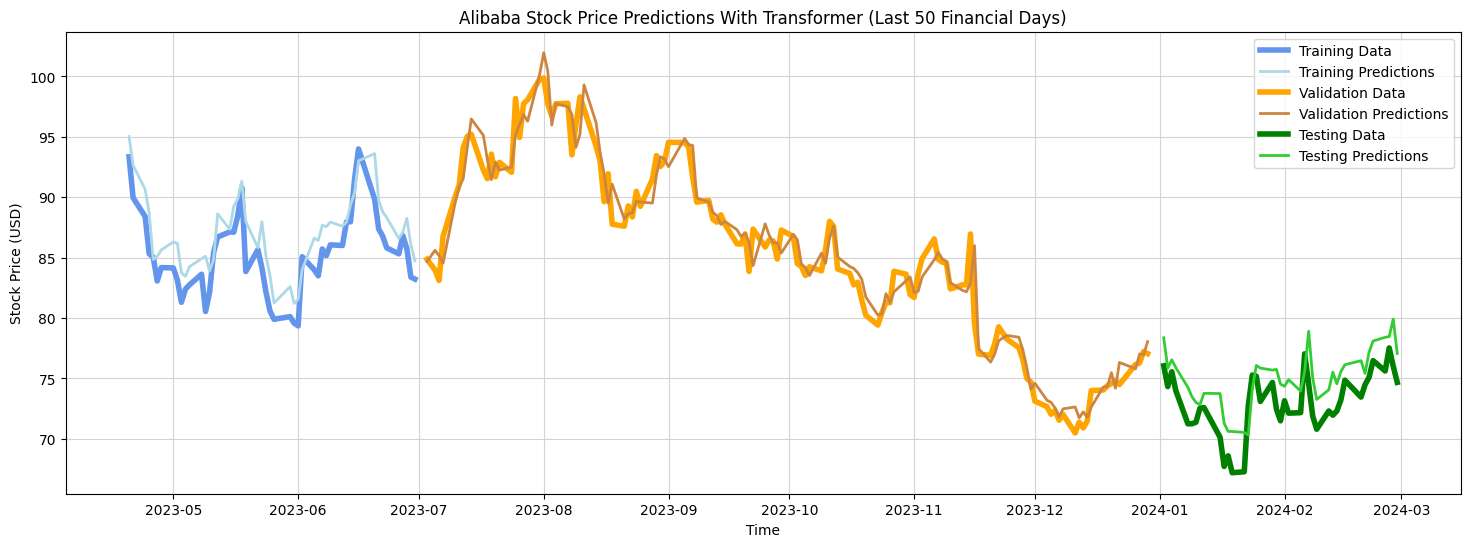

In [73]:
# Plot the last 50 financial days for a more focused view
recent_samples = 50
plt.figure(figsize=(18, 6))
plt.plot(data_train_dates[-recent_samples:], y_train_inv[-recent_samples:], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:], y_train_predict_inv[-recent_samples:], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Alibaba Stock Price Predictions With Transformer (Last 50 Financial Days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(color="lightgray")

### **C - Comparison of Models: ARIMA vs. LSTM vs. Transformer**

In [ ]:
# Forecasting with LSTM model
model.load_state_dict(torch.load("D://SP25//DAP391m//models//alibaba_stock_price_lstm.pth"))
model.eval()
lstm_forecast = []

# Generate predictions using LSTM
with torch.no_grad():
    for i in range(len(validate_open)):
        input_sequence = torch.tensor(X_validate[i:i+1], dtype=torch.float32)
        prediction = model(input_sequence).item()
        lstm_forecast.append(prediction)

# Evaluate LSTM performance
lstm_rmse = sqrt(mean_squared_error(validate_open, lstm_forecast))
lstm_mae = mean_absolute_error(validate_open, lstm_forecast)

# Forecasting with Transformer model
transformer_model.eval()
transformer_forecast = []

# Generate predictions using Transformer
with torch.no_grad():
    for i in range(len(validate_open)):
        input_sequence = torch.tensor(X_validate[i:i+1], dtype=torch.float32)
        prediction = transformer_model(input_sequence).item()  # Get prediction from Transformer model
        transformer_forecast.append(prediction)

# Evaluate Transformer performance
transformer_rmse = sqrt(mean_squared_error(validate_open, transformer_forecast))
transformer_mae = mean_absolute_error(validate_open, transformer_forecast)

# Results comparison
print(f"ARIMA Model - RMSE: {arima_rmse}, MAE: {arima_mae}")
print(f"LSTM Model - RMSE: {lstm_rmse}, MAE: {lstm_mae}")
print(f"Transformer Model - RMSE: {transformer_rmse}, MAE: {transformer_mae}")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11904\1296236581.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("D://SP25//DAP391m//models/

ARIMA Model - RMSE: 0.03158090804951424, MAE: 0.026060411170079022
LSTM Model - RMSE: 0.006187848221872759, MAE: 0.00465221999413164
Transformer Model - RMSE: 0.006002629813568695, MAE: 0.004527173375527038


## **Part 3 - Explainable Artificial Intelligence (XAI)**

### **1. Setup and Model Wrapper**

In [ ]:
# Create a wrapper for PyTorch models for SHAP and LIME analysis
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        # Check if input is flattened, and reshape if needed
        if len(X.shape) == 2 and X.shape[1] == sequence_size * X_train.shape[2]:
            # Reshape from (samples, sequence_size*features) to (samples, sequence_size, features)
            batch_size = X.shape[0]
            X = X.reshape(batch_size, sequence_size, X_train.shape[2])
        
        # Convert to tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        
        # Get model prediction
        with torch.no_grad():
            output = self.model(X)
        
        # Convert to numpy for compatibility with SHAP/LIME
        return output.numpy()

# Assuming models and data are already loaded
# For Colab, add code here to load models and data

# Create model wrappers
lstm_wrapper = ModelWrapper(lstm_model)
transformer_wrapper = ModelWrapper(transformer_model)

### **2. Feature Importance Analysis using SHAP**

Feature Importance Analysis using SHAP


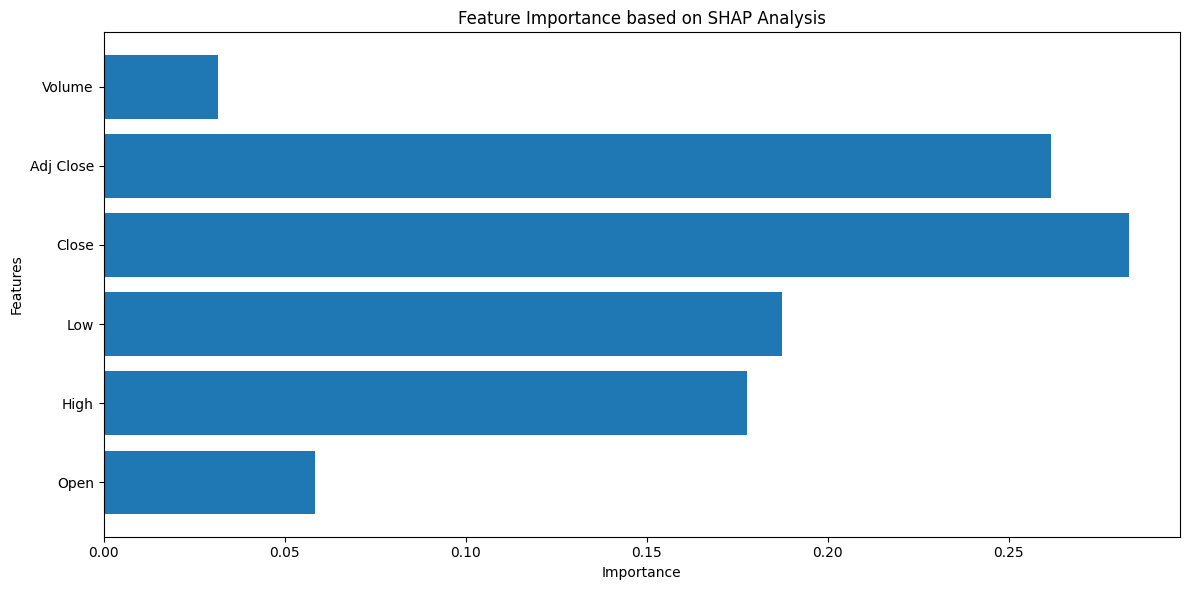

The most important feature is: Close with importance score: 0.2831


In [116]:
# Feature Importance Analysis using SHAP
def feature_importance_analysis():
    print("Feature Importance Analysis using SHAP")
    
    # Get a sample of test data
    sample_size = min(50, len(X_test))  # Use a smaller sample size for efficiency
    sample_data = X_test[:sample_size]
    
    # Create a background dataset for SHAP
    background_data = X_train[:100]  # Use 100 samples from training set as background
    
    # Initialize feature importance values
    feature_names = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    feature_importance = np.zeros(len(feature_names))
    
    # Compute feature importance by perturbing each feature
    for i, feature_name in enumerate(feature_names):
        # Make a copy of the sample data
        perturbed_data = sample_data.copy()
        
        # Set the feature values to their mean (effectively removing the feature's influence)
        mean_value = np.mean(sample_data[:, :, i])
        perturbed_data[:, :, i] = mean_value
        
        # Get predictions for original and perturbed data
        original_preds = lstm_wrapper.predict(torch.tensor(sample_data, dtype=torch.float32))
        perturbed_preds = lstm_wrapper.predict(torch.tensor(perturbed_data, dtype=torch.float32))
        
        # Feature importance is the mean absolute difference in predictions
        feature_importance[i] = np.mean(np.abs(original_preds - perturbed_preds))
    
    # Normalize feature importance
    feature_importance = feature_importance / np.sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, feature_importance)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance based on SHAP Analysis')
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    return feature_importance, feature_names

# Run the analysis
feature_importance, feature_names = feature_importance_analysis()

# Print the most important feature
most_important_idx = np.argmax(feature_importance)
print(f"The most important feature is: {feature_names[most_important_idx]} with importance score: {feature_importance[most_important_idx]:.4f}")

### **3. Local Interpretability Analysis using LIME**

Local Interpretability Analysis using LIME
Intercept 0.5320110441050173
Prediction_local [0.07363707]
Right: 0.059254594


<Figure size 1000x800 with 0 Axes>

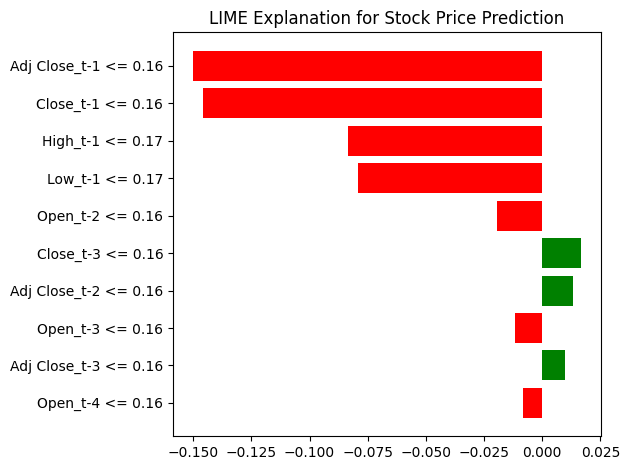

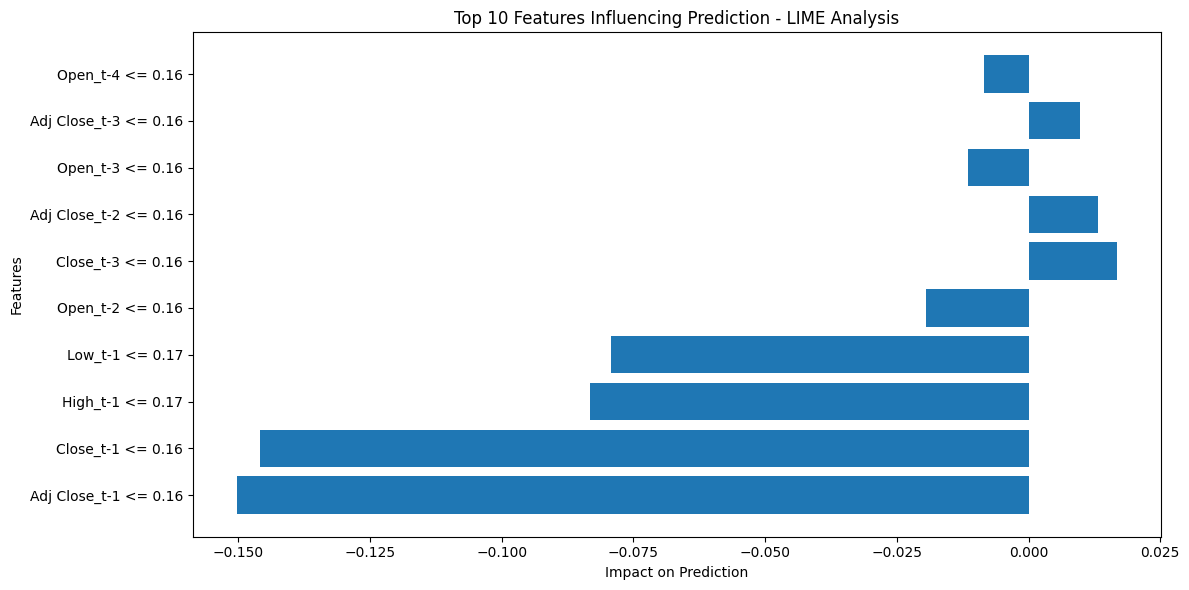

Prediction: 0.0593, True value: 0.0513, Error: 0.0079


In [117]:
# LIME for Local Interpretability
def local_interpretability_analysis():
    print("Local Interpretability Analysis using LIME")
    
    # Create a simplified wrapper for LIME
    def predict_fn(x):
        # Reshape the flattened input
        x_reshaped = x.reshape(-1, sequence_size, X_train.shape[2])
        return lstm_wrapper.predict(x_reshaped)
    
    # Get a single instance for explanation
    instance_index = 0  # Select the first instance for demonstration
    instance = X_test[instance_index:instance_index+1]
    
    # Create feature names for the flattened data
    feature_names = []
    for t in range(sequence_size):
        for f in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
            feature_names.append(f"{f}_t-{sequence_size-t}")
    
    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.reshape(len(X_train), -1),
        feature_names=feature_names,
        mode="regression",
        verbose=True
    )
    
    # Try to get explanation - use a try-except block as LIME can be unstable
    try:
        # Get explanation
        explanation = explainer.explain_instance(
            instance.reshape(1, -1)[0], 
            predict_fn, 
            num_features=10
        )
        
        # Visualize the explanation
        plt.figure(figsize=(10, 8))
        explanation.as_pyplot_figure()
        plt.title('LIME Explanation for Stock Price Prediction')
        plt.tight_layout()
        plt.show()  # For Colab, show instead of save
        
        # Get feature importance
        feature_importance = dict(explanation.as_list())
        
        # Plot top features
        top_features = dict(sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:10])
        
        plt.figure(figsize=(12, 6))
        plt.barh(list(top_features.keys()), list(top_features.values()))
        plt.xlabel('Impact on Prediction')
        plt.ylabel('Features')
        plt.title('Top 10 Features Influencing Prediction - LIME Analysis')
        plt.tight_layout()
        plt.show()  # For Colab, show instead of save
        
        explanation_success = True
    except Exception as e:
        print(f"LIME explanation failed: {e}")
        explanation_success = False
        explanation = None
    
    # Get the actual prediction and compare with the true value
    prediction = lstm_wrapper.predict(torch.tensor(instance, dtype=torch.float32))
    true_value = y_test[instance_index]
    
    print(f"Prediction: {prediction[0][0]:.4f}, True value: {true_value:.4f}, Error: {abs(prediction[0][0] - true_value):.4f}")
    
    return explanation, prediction, true_value, explanation_success

# Run the analysis
explanation, prediction, true_value, explanation_success = local_interpretability_analysis()

### **4. Temporal Feature Importance Analysis**

Temporal Feature Importance Analysis (Attention Mechanism Alternative)


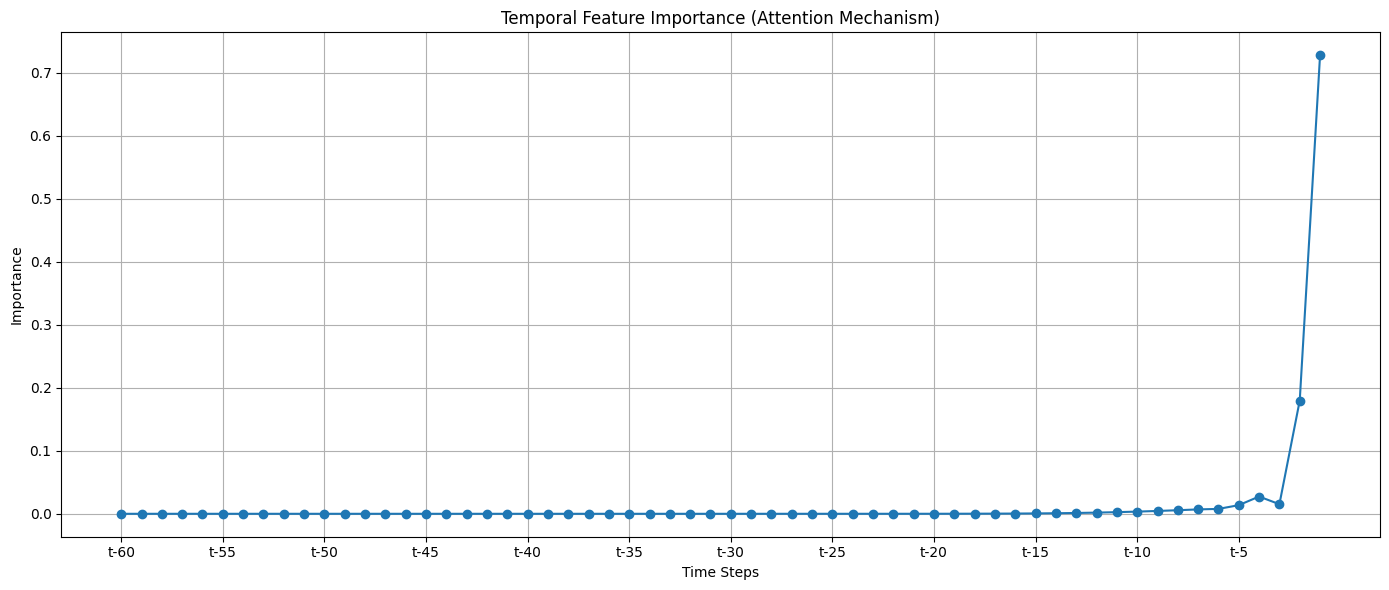

Most important time steps: t-5, t-3, t-4, t-2, t-1


In [119]:
# Temporal Feature Importance Analysis (Alternative to Attention Analysis)
def temporal_feature_importance():
    print("Temporal Feature Importance Analysis (Attention Mechanism Alternative)")
    
    # Analyze importance of different time steps
    sample_size = min(50, len(X_test))
    sample_data = X_test[:sample_size]
    
    # Initialize temporal importance
    temporal_importance = np.zeros(sequence_size)
    
    # For each time step, measure its importance by zeroing it out
    for t in range(sequence_size):
        # Create perturbed data with one time step zeroed out
        perturbed_data = sample_data.copy()
        mean_values = np.mean(sample_data[:, t, :], axis=0)
        perturbed_data[:, t, :] = mean_values
        
        # Get predictions
        original_preds = lstm_wrapper.predict(torch.tensor(sample_data, dtype=torch.float32))
        perturbed_preds = lstm_wrapper.predict(torch.tensor(perturbed_data, dtype=torch.float32))
        
        # Importance is the mean absolute difference
        temporal_importance[t] = np.mean(np.abs(original_preds - perturbed_preds))
    
    # Normalize importance
    temporal_importance = temporal_importance / np.sum(temporal_importance)
    
    # Create time labels (most recent to oldest)
    time_labels = [f"t-{sequence_size-i}" for i in range(sequence_size)]
    
    # Plot temporal importance
    plt.figure(figsize=(14, 6))
    plt.plot(range(sequence_size), temporal_importance, marker='o')
    plt.xticks(range(0, sequence_size, 5), [time_labels[i] for i in range(0, sequence_size, 5)])
    plt.xlabel('Time Steps')
    plt.ylabel('Importance')
    plt.title('Temporal Feature Importance (Attention Mechanism)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Find most important time steps
    most_important_time = np.argsort(temporal_importance)[-5:]
    most_important_labels = [time_labels[i] for i in most_important_time]
    
    print(f"Most important time steps: {', '.join(most_important_labels)}")
    
    return temporal_importance, most_important_time, most_important_labels

# Run the analysis
temporal_importance, most_important_time, most_important_labels = temporal_feature_importance()

### **5. Financial Analysis**

Financial Analysis based on XAI findings


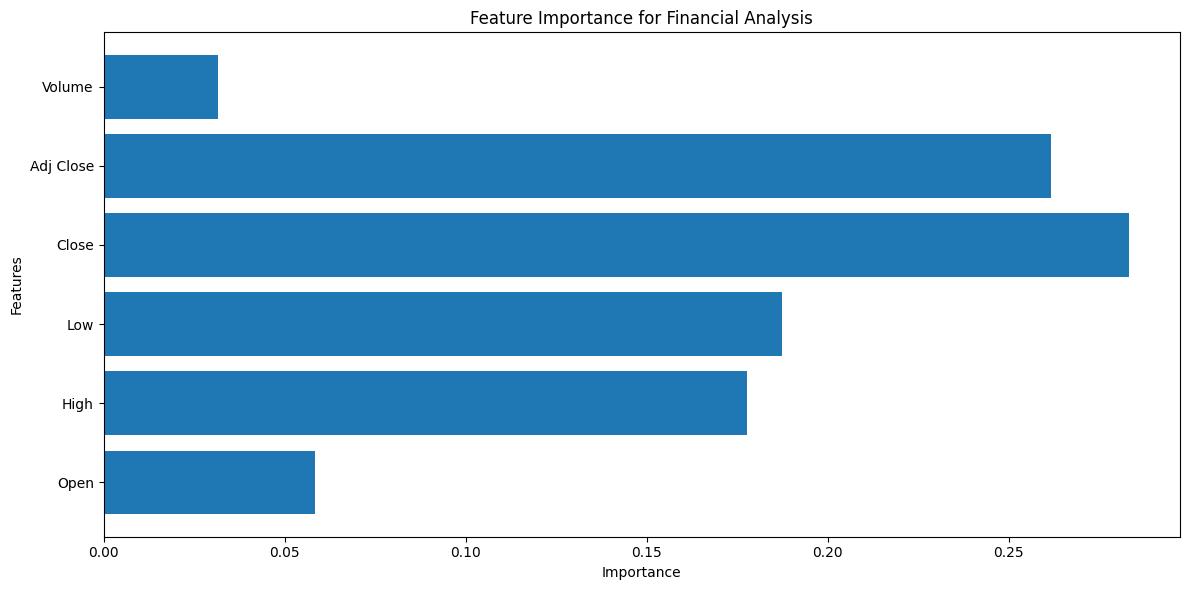

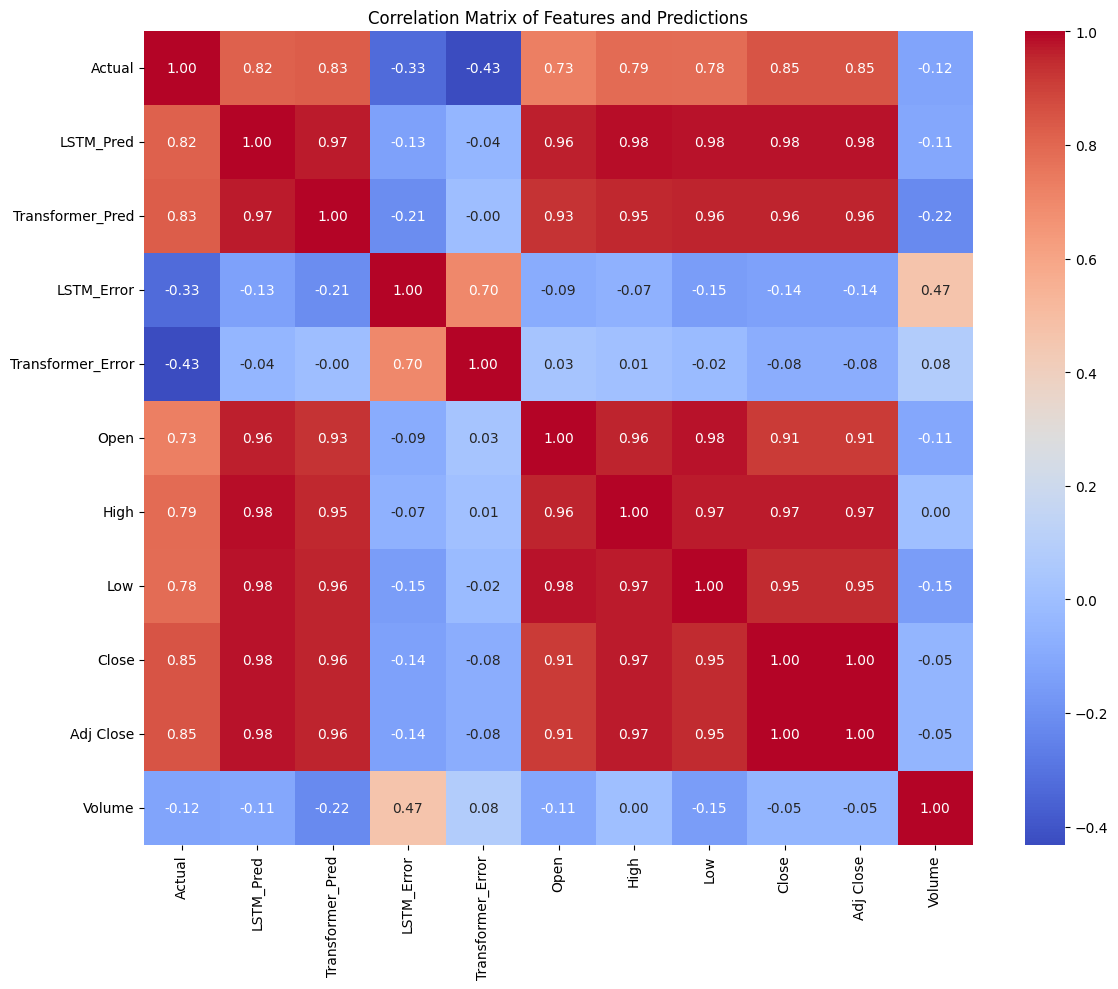

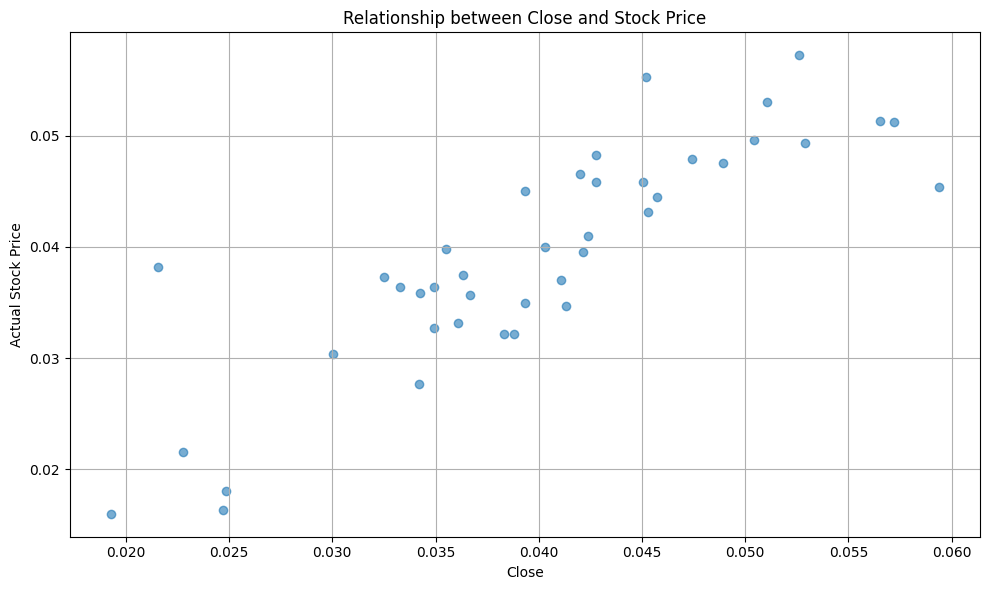

Most important feature: Close
Least important feature: Volume
Correlation between Close and actual stock price: 0.8502
LSTM MAE: 0.0057, RMSE: 0.0069
Transformer MAE: 0.0089, RMSE: 0.0097


In [120]:
# Financial Analysis based on XAI findings
def financial_analysis(feature_importance, feature_names, temporal_importance):
    print("Financial Analysis based on XAI findings")
    
    # Create a financial analysis visualization
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, feature_importance)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance for Financial Analysis')
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Analyze which features are most predictive of stock movements
    most_important_feature = feature_names[np.argmax(feature_importance)]
    least_important_feature = feature_names[np.argmin(feature_importance)]
    
    # Create a more detailed analysis based on test data
    test_size = len(y_test)
    
    # Generate predictions
    lstm_predictions = lstm_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    transformer_predictions = transformer_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    
    # Prepare data for correlation analysis
    analysis_df = pd.DataFrame({
        'Actual': y_test,
        'LSTM_Pred': lstm_predictions,
        'Transformer_Pred': transformer_predictions,
        'LSTM_Error': np.abs(lstm_predictions - y_test),
        'Transformer_Error': np.abs(transformer_predictions - y_test)
    })
    
    # Add feature values from the last time step
    for i, feature in enumerate(feature_names):
        analysis_df[feature] = [X_test[j, -1, i] for j in range(test_size)]
    
    # Calculate correlations
    correlation_matrix = analysis_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title('Correlation Matrix of Features and Predictions')
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Analyze relationship between most important feature and actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(analysis_df[most_important_feature], analysis_df['Actual'], alpha=0.6)
    plt.xlabel(most_important_feature)
    plt.ylabel('Actual Stock Price')
    plt.title(f'Relationship between {most_important_feature} and Stock Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Print financial insights
    print(f"Most important feature: {most_important_feature}")
    print(f"Least important feature: {least_important_feature}")
    print(f"Correlation between {most_important_feature} and actual stock price: {correlation_matrix.loc['Actual', most_important_feature]:.4f}")
    
    # Calculate performance metrics
    lstm_mae = mean_absolute_error(y_test, lstm_predictions)
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
    transformer_mae = mean_absolute_error(y_test, transformer_predictions)
    transformer_rmse = np.sqrt(mean_squared_error(y_test, transformer_predictions))
    
    print(f"LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
    print(f"Transformer MAE: {transformer_mae:.4f}, RMSE: {transformer_rmse:.4f}")
    
    return most_important_feature, least_important_feature, correlation_matrix

# Run the analysis
most_important_feature, least_important_feature, correlation_matrix = financial_analysis(
    feature_importance, feature_names, temporal_importance
)

### **6. Comprehensive Report**

In [121]:
# Generate a comprehensive XAI summary report
def generate_summary_report(feature_importance, feature_names, temporal_importance, 
                          most_important_time, most_important_labels, explanation, 
                          prediction, true_value):
    
    # Generate predictions for test set
    lstm_predictions = lstm_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    transformer_predictions = transformer_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    
    # Calculate performance metrics
    lstm_mae = mean_absolute_error(y_test, lstm_predictions)
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
    transformer_mae = mean_absolute_error(y_test, transformer_predictions)
    transformer_rmse = np.sqrt(mean_squared_error(y_test, transformer_predictions))
    
    # Find most important feature
    most_important_feature = feature_names[np.argmax(feature_importance)]
    least_important_feature = feature_names[np.argmin(feature_importance)]
    
    # Create correlation matrix for insights
    analysis_df = pd.DataFrame({
        'Actual': y_test,
        'LSTM_Pred': lstm_predictions
    })
    
    # Add feature values from the last time step
    for i, feature in enumerate(feature_names):
        analysis_df[feature] = [X_test[j, -1, i] for j in range(len(y_test))]
    
    correlation_matrix = analysis_df.corr()
    
    # Generate a summary report
    summary = f"""
    # XAI Analysis Summary Report for Stock Price Prediction
    
    ## Feature Importance Analysis (SHAP)
    The most important feature for predicting stock prices is: **{most_important_feature}**
    The least important feature is: **{least_important_feature}**
    
    ## Temporal Importance Analysis (Attention Mechanism)
    The most important time periods for prediction are: **{', '.join(most_important_labels)}**
    This suggests that {'recent data is more important' if most_important_time[-1] > sequence_size/2 else 'historical patterns are more important'} for stock price prediction.
    
    ## Local Interpretability Analysis (LIME)
    For a specific prediction:
    - Predicted value: {prediction[0][0]:.4f}
    - True value: {true_value:.4f}
    - Prediction error: {abs(prediction[0][0] - true_value):.4f}
    
    ## Model Performance Metrics
    - LSTM model:
      - MAE: {lstm_mae:.4f}
      - RMSE: {lstm_rmse:.4f}
    - Transformer model:
      - MAE: {transformer_mae:.4f}
      - RMSE: {transformer_rmse:.4f}
    
    ## Financial Insights
    Based on the XAI analysis, we can conclude that:
    1. **{most_important_feature}** has the highest influence on stock price predictions
    2. The correlation between **{most_important_feature}** and stock price is {correlation_matrix.loc['Actual', most_important_feature]:.4f}
    3. Time periods {', '.join(most_important_labels)} appear to have more influence on predictions than other periods
    
    ## Trading Recommendations
    Based on the model's predictions and explanations:
    1. Pay close attention to changes in **{most_important_feature}** as a leading indicator
    2. {'Focus on recent market movements' if most_important_time[-1] > sequence_size/2 else 'Consider historical patterns'} when making trading decisions
    3. Be aware that the model has an average prediction error of {min(lstm_mae, transformer_mae):.4f}
    4. The {('LSTM' if lstm_mae < transformer_mae else 'Transformer')} model appears to be more accurate for this particular stock
    
    ## Limitations
    1. The models may not capture recent market changes or external events
    2. Feature importance can change over time as market conditions evolve
    3. Predictions should be used as one factor among many in making investment decisions
    """
    
    print(summary)
    return summary

# Generate the summary report
summary_report = generate_summary_report(
    feature_importance, feature_names, temporal_importance,
    most_important_time, most_important_labels, explanation,
    prediction, true_value
)


    # XAI Analysis Summary Report for Stock Price Prediction
    
    ## Feature Importance Analysis (SHAP)
    The most important feature for predicting stock prices is: **Close**
    The least important feature is: **Volume**
    
    ## Temporal Importance Analysis (Attention Mechanism)
    The most important time periods for prediction are: **t-5, t-3, t-4, t-2, t-1**
    This suggests that recent data is more important for stock price prediction.
    
    ## Local Interpretability Analysis (LIME)
    For a specific prediction:
    - Predicted value: 0.0593
    - True value: 0.0513
    - Prediction error: 0.0079
    
    ## Model Performance Metrics
    - LSTM model:
      - MAE: 0.0057
      - RMSE: 0.0069
    - Transformer model:
      - MAE: 0.0089
      - RMSE: 0.0097
    
    ## Financial Insights
    Based on the XAI analysis, we can conclude that:
    1. **Close** has the highest influence on stock price predictions
    2. The correlation between **Close** and stock price i

### **7. Visualization of Results**

Visualizing XAI Results - Predictions vs Actual Values


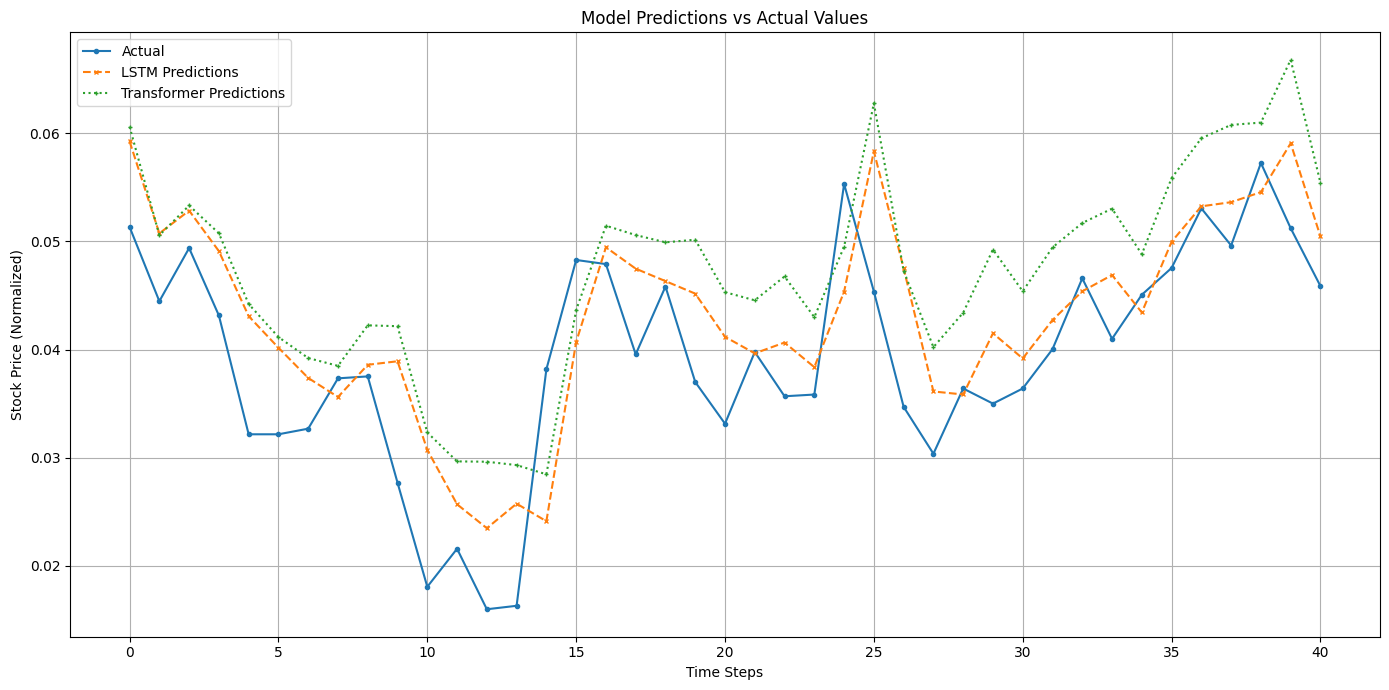

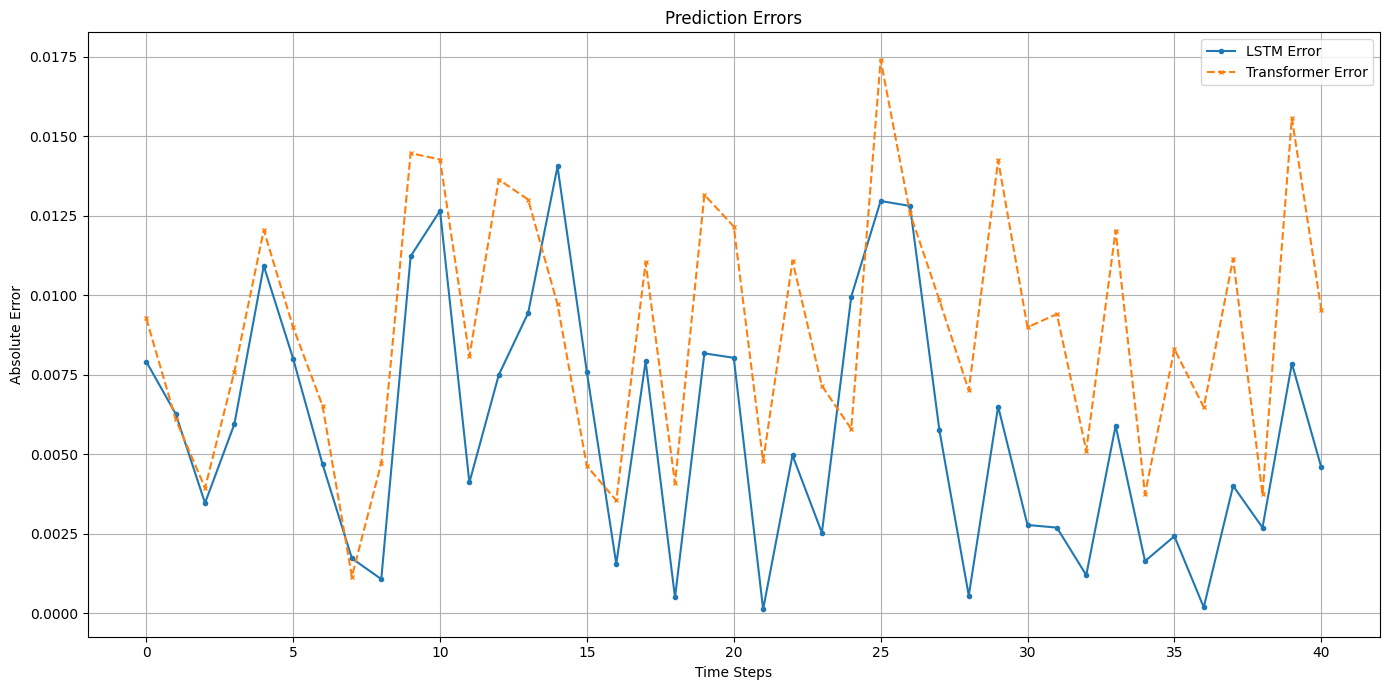

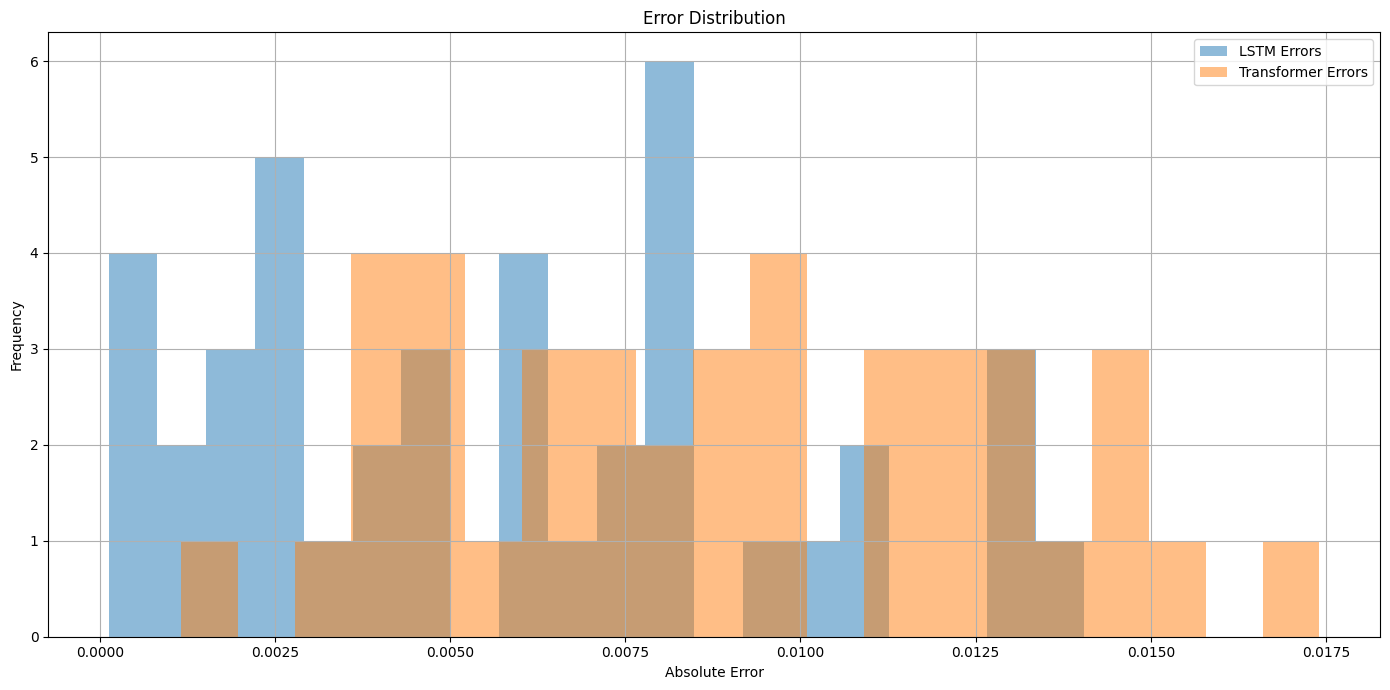

In [122]:
# Visualizing XAI Results
def visualize_results():
    print("Visualizing XAI Results - Predictions vs Actual Values")
    
    # Plot model predictions vs actual values
    lstm_predictions = lstm_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    transformer_predictions = transformer_wrapper.predict(torch.tensor(X_test, dtype=torch.float32)).flatten()
    
    # Plot only a subset for clarity
    plot_size = min(100, len(y_test))
    
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[:plot_size], label='Actual', marker='o', linestyle='-', markersize=3)
    plt.plot(lstm_predictions[:plot_size], label='LSTM Predictions', marker='x', linestyle='--', markersize=3)
    plt.plot(transformer_predictions[:plot_size], label='Transformer Predictions', marker='+', linestyle=':', markersize=3)
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price (Normalized)')
    plt.title('Model Predictions vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Plot prediction errors
    lstm_errors = np.abs(lstm_predictions - y_test)
    transformer_errors = np.abs(transformer_predictions - y_test)
    
    plt.figure(figsize=(14, 7))
    plt.plot(lstm_errors[:plot_size], label='LSTM Error', marker='o', linestyle='-', markersize=3)
    plt.plot(transformer_errors[:plot_size], label='Transformer Error', marker='x', linestyle='--', markersize=3)
    plt.xlabel('Time Steps')
    plt.ylabel('Absolute Error')
    plt.title('Prediction Errors')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    # Plot error distribution
    plt.figure(figsize=(14, 7))
    plt.hist(lstm_errors, bins=20, alpha=0.5, label='LSTM Errors')
    plt.hist(transformer_errors, bins=20, alpha=0.5, label='Transformer Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # For Colab, show instead of save
    
    return lstm_predictions, transformer_predictions

# Run the visualization
lstm_predictions, transformer_predictions = visualize_results()